# Optimizador de rutas de camiones Saputo

In [1]:
import csv
import math
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

## Constantes:

In [2]:
MAX_DELIVERIES = 10 #Cantidad de camiones 
DRIVE_SPEED_KMPH = 20 #Velocidad promedio
PRICE_PER_TRUCK = 100 #Precio del día 
PRICE_PER_KM = 0.061 #precio EUR
MAX_TIME_PER_TRUCK = 10 #horas
TOTAL_CLUSTERS = 35 #Modificado inicialmente eran 51

In [3]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

## Objetos en el Sistema

In [4]:
class Truck:
    id = 0

    def __init__(self,orders):
        self.capacity_left = MAX_DELIVERIES
        self.x = 0
        self.y = 0
        self.current_time = 0
        self.id = Truck.id
        self.deliveries = []  # [truck_id, order_id, seq_no]
        self.current_order = 1
        self.delivered = False
        self.orders = orders
        Truck.id += 1

    def can_deliver_order(self, order):
        """
        Comprueba si el camión puede entregar el pedido y llegar al depósito a tiempo.
        """
        if self.capacity_left == 0:
            return False

        time_to_reach_order = distance(self.x, self.y, order.x, order.y) / DRIVE_SPEED_KMPH

        if self.current_time + time_to_reach_order >= order.end_time:
            return False

        time_to_reach_depot = distance(order.x, order.y, 0, 0) / DRIVE_SPEED_KMPH

        if (
            max(self.current_time + time_to_reach_order, order.start_time)
                + time_to_reach_depot > MAX_TIME_PER_TRUCK
        ):
            return False

        print("True")
        return True

    def deliver_order(self, order):
        dist = distance(self.x, self.y, order.x, order.y)

        # Actualiza current_time
        self.current_time = max(
            self.current_time + (dist / DRIVE_SPEED_KMPH),
            order.start_time
        )

        # Actualiza capacity
        self.capacity_left -= 1

        # Actualiza ubicación
        self.x = order.x
        self.y = order.y

        # agrega orden a las entregas
        self.deliveries.append([self.id, order.id, self.current_order,self.current_time])
        self.current_order += 1

    def deliver(self):
        self.delivered = True
        new_route = self.optimise_route()
        new_route = list(map(lambda x: x[:-1], new_route))
        
        return new_route[::]
    
    # optimización local de la ruta a través de cluster
    def optimise_route(self):
        def cost_btwn_orders(o1,o2):
            loc1 = (o1.x,o2.y)
            loc2 = (o2.x,o2.y)
            return distance(loc1[0],loc1[1],loc2[0],loc2[1])   
        
        del_copy = self.deliveries[::]
        for i in range(len(del_copy)-3):
            # vemos si el camino v1->v2->v3->v4 puede ser optimizado a v1->v3->v2->v4
            v1, v2, v3, v4 = self.orders[int(del_copy[i][1])], self.orders[int(del_copy[i+1][1])], self.orders[int(del_copy[i+2][1])], self.orders[int(del_copy[i+3][1])]
            if(cost_btwn_orders(v1,v2) + cost_btwn_orders(v2,v3)+cost_btwn_orders(v3,v4) >
            cost_btwn_orders(v1,v3) + cost_btwn_orders(v3,v2)+cost_btwn_orders(v2,v4)):
                # comprueba la limitación de tiempo con un nuevo pedido
                time_at_3 = max(del_copy[i][3] + (cost_btwn_orders(v1,v3) / DRIVE_SPEED_KMPH),v3.start_time)
                time_at_2 = max(time_at_3 + (cost_btwn_orders(v3,v2) / DRIVE_SPEED_KMPH), v2.start_time)
                time_at_4 = max(time_at_2 + (cost_btwn_orders(v2,v4) / DRIVE_SPEED_KMPH), v4.start_time)
                
                if(time_at_3 < v3.end_time and time_at_2 < v2.end_time and time_at_4 < v4.end_time):
                    if i+3 == len(del_copy)-1:
                        if time_at_4 + (distance(v4.x,v4.y,0.0,0.0) / DRIVE_SPEED_KMPH) > 10:
                            break
                    # las limitaciones de tiempo se cumplieron, ahora intercambien.
                    del_copy[i+1][2],del_copy[i+2][2] = del_copy[i+2][2],del_copy[i+1][2]
                    del_copy[i+2][3] = time_at_3
                    del_copy[i+1][3] = time_at_2
                    del_copy[i+3][3] = time_at_4
                    
                    del_copy[i+1],del_copy[i+2]=del_copy[i+2],del_copy[i+1]
        return del_copy
                
            
    def has_delivered(self):
        return self.delivered

In [5]:
class Order:
    def __init__(self, id, x, y, start_time):
        self.id = id
        self.x = x
        self.y = y
        self.start_time = start_time
        self.end_time = self.start_time + 1

## Algoritmo de ruteo:

In [6]:
def clustered(orders, kmeans): #usamos kmeans como clasificador, TENER UNA VARIABLE MAS CON TIEMPO
    clusters = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
    deliveries = []

    current_truck = Truck(orders[::])

    # bucle sobre cada cluster
    for cluster in clusters.values():
        curr_len = len(deliveries)

        orders_in_cluster = [orders[idx] for idx in cluster]

        for order in sorted(orders_in_cluster, key=lambda x: x.end_time):
            if current_truck.can_deliver_order(order):
                current_truck.deliver_order(order)
            else:
                deliveries.extend(current_truck.deliver())
                current_truck = Truck(orders[::])
                current_truck.deliver_order(order)

    if not current_truck.has_delivered():
        deliveries.extend(current_truck.deliver())

    return deliveries

### Encontrar clusters, ejecutar "algo", formatear la salida

In [7]:
def answer():
    df = pd.read_csv("C:/Users/jdiaz/Downloads/orders1.csv")

    orders_to_cluster = []
    orders = []

    for _, row in df.iterrows():
        orders_to_cluster.append([row["x"], row["y"]])
        order = Order(
            row["order_id"], row["x"], row["y"], row["time_window_start"]
        )
        orders.append(order)

    kmeans = KMeans(n_clusters=TOTAL_CLUSTERS, random_state=0)
    kmeans.fit(orders_to_cluster)

    #print(len(orders))

    # ans_list = bruteforce(orders)
    ans_list = clustered(orders, kmeans)

    #print(len(ans_list))

    with open("answer.txt", 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["truck_id", "order_id", "sequence_number"])
        for row in ans_list:
            writer.writerow(row)

## Versión adaptada del validador para comprobar "algo":

In [8]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,40)
import matplotlib.pyplot as plt
%matplotlib inline  

"""
"""

import sys
import math
import pandas as pd


MAX_DELIVERIES = 10
DRIVE_SPEED_KMPH = 20
PRICE_PER_TRUCK = 100
PRICE_PER_KM = 0.061

def distance1(pos1, pos2):
    "Encuentra la distancia euclidiana entre dos, dos tuplas dimensionales"
    diff_1 = pos1[0] - pos2[0]
    diff_2 = pos1[1] - pos2[1]
    return math.sqrt(diff_1*diff_1 + diff_2*diff_2)


def is_valid(data_frame):
    "Compruebe si la ruta prevista para un camión es legal. Imprime cualquier problema para evitar..."
    epsilon = 0.00001
    check = data_frame.copy()
    check.sort_values("sequence_number", inplace=True)
    location = (0, 0)
    time = 0
    valid = []
    # Revisa que todas las entregas hagan sus ventanas de tiempo
    row = ""
    for _, row in check.iterrows():
        new_location = (row.x, row.y)
        travel_time_hours = distance1(location, new_location) / DRIVE_SPEED_KMPH
        time = time + travel_time_hours
        if time > row.time_window_start+1:
            sys.stderr.write("Error: Truck " + str(row.truck_id)
                             + " delivers to " + str(row.order_id)
                             + " late at " + str(time) + "\n")
            valid.append(False)
        else:
            valid.append(True)
        if time - epsilon < row.time_window_start:
            time = row.time_window_start
        location = new_location

    # Revisa que la camioneta regrese al depósito a tiempo
    new_location = (0, 0)
    travel_time_hours = distance1(location, new_location) / DRIVE_SPEED_KMPH
    time = time + travel_time_hours
    if time - epsilon > 10:
        sys.stderr.write("Error: Truck " + str(row.truck_id)
                         + " returns to the depot at " + str(time) + "\n")
        valid = [False] * len(check)

    # Revisa que la furgoneta haga como mucho 10 entregas
    if len(check) > MAX_DELIVERIES:
        sys.stderr.write("Error: Truck " + str(row.truck_id)
                         + " delivers to " + str(len(check)) + " orders.\n")
        valid = [False] * len(check)
    return valid


def route_distance(data_frame):
    """Check if the route provided for a truck is legal.
       Print any problems to stderr"""
    check = data_frame.copy()
    check.sort_values("sequence_number", inplace=True)
    location = (0, 0)
    total_distance = 0
    # Suma las distancias a la última orden
    for _, row in check.iterrows():
        new_location = (row.x, row.y)
        total_distance += distance1(location, new_location)
        location = new_location

    # Agrega distancia al depósito
    new_location = (0, 0)
    total_distance += distance1(location, new_location)

    return total_distance


def check(file_name):
    " Encuentra la puntuación para la solución y reporta cualquier problema"
    # Las Columnas son: truck_id, order_id, sequence_number
    data = pd.read_csv(file_name)
    data.columns = [column.strip() for column in data.columns.tolist()]
    # Las Columnas son: order_id, x, y, time_window_start
    orders = pd.read_csv("C:/Users/jdiaz/Downloads/orders1.csv")
    orders.columns = [column.strip() for column in orders.columns.tolist()]
    data = data.merge(orders, on="order_id")

    # Verifique las órdenes únicas correctas...
    specified_orders = data.order_id.nunique()
    if specified_orders != len(orders):
        sys.stderr.write("Error: " + str(specified_orders) + " specified. "
                         + str(len(orders)) + " orders required.\n")
        exit(1)

    # Revise las órdenes duplicadas especificadas
    duplicates = data.order_id.duplicated()
    if sum(duplicates):
        msg = "Error:la(s) siguiente(s) orden(es) tiene(n) múltiples entregas:\n"
        duplicated_orders = data[duplicates].groupby("order_id")
        duplicated_orders = duplicated_orders.mean().reset_index().order_id
        duplicated_orders = duplicated_orders.values.tolist()
        sys.stderr.write(msg + str(duplicated_orders) + "\n")
        exit(1)

     # Verificar la validez de las rutas
    valid = data.groupby("truck_id").apply(is_valid).tolist()
    valid = [x for sublist in valid for x in sublist]
    total_distance = sum(data.groupby("truck_id").apply(route_distance))

    if not sum(valid) == len(data):
        print("Invalid solution")
        exit(1)
    else:
        vans = data.truck_id.nunique()
        #print("Correct solution found with "
             # + str(vans) + " trucks.")
        #print("Total distance travelled: {0:.2f}".format(total_distance)
             # + " km")
        cost = vans*100 + total_distance*0.061
        #print("Total cost: £{0:.2f}".format(cost))
        return (vans,total_distance,cost)

In [9]:
# Ejecuta "algo", y obtiene los resultados de la evaluación
def pipeline():
    answer()
    results = check("answer.txt")
    return results

In [10]:
# Optimización del número de clusters...

# cs = []
# costs = []
# for i in range(1,200,2):
#    TOTAL_CLUSTERS = i
#    cost = pipeline()[2]
#    cs += [i]
#    costs += [cost]
# plt.plot(cs,costs)

In [11]:
TOTAL_CLUSTERS = 35 #opcional 
results = pipeline()

True
True
True
True
True
True
True
True
True
True
True
True


In [12]:
results # evaluamos los resultados

(24, 2311.9588717108763, 2541.0294911743636)

## Visualización de la Ruta:

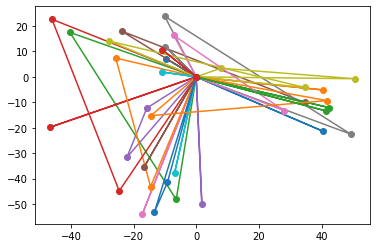

In [13]:
orders = []
with open("C:/Users/jdiaz/Downloads/orders1.csv") as f:
    count = 0
    for line in f:
        count += 1
        if count == 1:
            continue
        orders+=[ list(map(lambda x:float(x), line.replace('\n','').split(',')) )]
#print(orders)
journeys = {}
count = 0
with open('answer.txt') as f:
    for line in f:
        count += 1
        if count == 1:
            continue
        data = line.split(',')
        truck = data[0]
        order = int(float(data[1]))
        order_x = orders[order][1]
        order_y = orders[order][2]
        #print (order_x,order_y)
        if truck not in journeys.keys():
            journeys[truck] = [((0.0,0.0),(order_x,order_y))]
        else:
            last_loc = journeys[truck][-1][1]
            journeys[truck] += [(last_loc,(order_x,order_y))]
for truck in journeys.keys():
    last_loc = journeys[truck][-1][1]
    journeys[truck] += [(last_loc,(0.0,0.0))]

for truck in journeys.keys():
    xs = [0.0]+list([x[1][0] for x in journeys[truck]])
    ys = [0.0]+list([x[1][1] for x in journeys[truck]])

    plt.plot(xs,ys,'-o')
matplotlib.rcParams['figure.figsize'] = (16,20)
#plt.legend(loc=4)
plt.show()